In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## In this notebook,I will learn the high level of tensorflow API invoke :
    1.using predefine Model
    2.create dataset out of memory
    3.distribution train
    4.monitor training processing
    5.deploy your model

## 1. PreDefine Model
<a href='https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor#train'>LinearRegressor</a>

In [ ]:
class MyModel():
    def __init__(self,filename='outputs/tf_week2/model1'):
        self.columns=['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
        features=[tf.feature_column.numeric_column(f) for f in self.columns]
        self.model=tf.estimator.LinearRegressor(feature_columns=features,model_dir=filename)
        tf.logging.set_verbosity(tf.logging.INFO)
    def make_train_input_fn(self,epochs):
        df_train=pd.read_csv('../AI_database/trips/taxi-train.csv')
        return tf.estimator.inputs.pandas_input_fn(x=df_train,
                                        y=df_train['fare_amount'],
                                        batch_size=128,
                                        num_epochs=epochs,
                                        shuffle=True,
                                        queue_capacity=1000)
    def make_valid_input_fn(self):
        df_dev=pd.read_csv('../AI_database/trips/taxi-valid.csv')
        return tf.estimator.inputs.pandas_input_fn(x=df_dev,
                                              y=df_dev["fare_amount"],
                                              batch_size=128,
                                              num_epochs=1,
                                              shuffle=True,
                                              queue_capacity=1000)
    def make_predict_input_fn(self):
        df_test=pd.read_csv('../AI_database/trips/taxi-test.csv')
        return tf.estimator.inputs.pandas_input_fn(x=df_test,y=None,
                                              batch_size=128,num_epochs=1,
                                              shuffle=False)
    def fit(self,epochs=10):
        self.model.train(self.make_train_input_fn(epochs))
    def evaluate(self):
        result=self.model.evaluate(self.make_valid_input_fn())
        print('Eval rms is {}'.format(np.sqrt(result['average_loss'])))
    def predict(self):
        return self.model.predict(self.make_predict_input_fn())

In [ ]:
model=MyModel('outputs/tf_week2/model1')
print('Train  Step:')
model.fit(1)
print('Evaluatuin Step:')
model.evaluate()

In [ ]:
#take a look at train,valid,test input function
print(model.make_train_input_fn(1)()) #give 2 node, features(map) and label(a tensor)
print('--------------------------------------')
print(model.make_valid_input_fn()()) #give 2 node, features(map) and label(a tensor)
print('--------------------------------------')
print(model.make_predict_input_fn()())

## 2. training on large dataset,using tf.data.* instead of  tf.estimator.input.pandas_input_fn 

In [ ]:
#input a raw line,return features and labels
def decoder(row):
    cols=tf.decode_csv(row,[[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    features={'pickuplon':cols[1],'pockuplat':cols[2]}
    label=cols[0]
    return features,label

### first let's see how dataset tensor work

In [ ]:
! head ../AI_database/trips/taxi-train.csv -n11

In [ ]:
#the workflow look like follow:
'''
    filename->TextDataset->shuffle->batch->repeat->map->iterator->next
    all about are node or tensor in TF
    
    the output should have the format for model.train()
    {featurename:tensor},label tensor
'''
dataset=tf.data.TextLineDataset('../AI_database/trips/taxi-train.csv')
dataset=dataset.skip(1)

dataset=dataset.map(decoder)
dataset=dataset.batch(3)
dataset.shuffle(1000)
mynext=dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    for i in range(5):
        print(sess.run(mynext))

In [ ]:
class MyModel2(MyModel):
    def decoder_line(self,row):
        DEFAULTS = [[0.0], [-74.0], [40.0], [-74.0], [40.7], [1.0], ['nokey']]
        cols=tf.decode_csv(row,DEFAULTS)
        features={self.columns[i]:cols[i+1] for i in range(0,len(self.columns))}
        labels=cols[0]
        return features,labels
    def _getDataset(self,filename,epochs):
        def ret_func():
            dataset=tf.data.Dataset.list_files(filename)
            dataset=dataset.flat_map(tf.data.TextLineDataset)
            dataset=dataset.skip(1)
            dataset=dataset.shuffle(1000)
            dataset=dataset.batch(128)
            dataset=dataset.repeat(epochs)
            dataset=dataset.map(lambda r:self.decoder_line(r))   
            features,labels=dataset.make_one_shot_iterator().get_next()
            return features,labels
        return ret_func
    
    def make_train_input_fn(self,epochs):
        print('======================Model 2 using large dataset======================')
        return self._getDataset('../AI_database/trips/taxi-train.csv',epochs)
    def make_valid_input_fn(self):
        print('======================Model 2 using large dataset======================')
        return self._getDataset('../AI_database/trips/taxi-valid.csv',1)
    def make_predict_input_fn(self):
        print('======================Model 2 using large dataset======================')
        return self._getDataset('../AI_database/trips/taxi-test.csv',1)

In [ ]:
model=MyModel2('outputs/tf_week2/model2')
print('Train step:')
model.fit(1)
print('Evaluation step:')
model.evaluate()

In [ ]:
gen=model.predict()
for i in range(5):
    print(next(gen))

In [ ]:
for v_name in model.model.get_variable_names():
    print('{} : {}'.format(v_name,model.model.get_variable_value(v_name)))

In [ ]:
pd.read_csv('../AI_database/trips/taxi-valid.csv').head(1)

In [ ]:
-73.988954*-0.03677155+40.758612*0.05220714+-73.952118*-0.04987059+40.776227*0.05605096*2*0.92487079+0.07902358

## 3.big jobs distribution training
        1.define a run_config 
        2.define your model LinearRegression
        3.Define trainSpec  <a href='http://ss'>TrainSpec</a>
        4.Define evalSpec <a href=''>EvalSpec</a>
        5.call tf.estimator.train_and_eval(model,train_spec,eval_spec)
<a href='https://www.tensorflow.org/api_docs/python/tf/estimator/RunConfig'>RunConfig</a> <a href='https://www.tensorflow.org/api_docs/python/tf/estimator/TrainSpec'>TrainSpec</a> <a href='https://www.tensorflow.org/api_docs/python/tf/estimator/EvalSpec#__new__'>EvalSpec</a>
 <a href='https://www.tensorflow.org/api_docs/python/tf/estimator/export/ServingInputReceiver#__new__'>ServingInputReceiver</a>
  <a href='https://www.tensorflow.org/api_docs/python/tf/estimator/LatestExporter'>LatestExporter</a>

In [ ]:
class MyModel3(MyModel2):
    def __init__(self,filename='outputs/tf_week2/model1'):
        self.columns=['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
        features=[tf.feature_column.numeric_column(f) for f in self.columns]
        runconfig=tf.estimator.RunConfig(filename,save_summary_steps=100,save_checkpoints_steps=1000)
        self.model=tf.estimator.LinearRegressor(feature_columns=features,config=runconfig)
    
    def fit(self,epoch):
        # Defines the expected shape of the JSON feed that the model,will receive once 
        #deployed behind a REST API in production.
        def serving_input_fn():
            feature_placeholders = {
                'pickuplon' : tf.placeholder(tf.float32, [None]),
                'pickuplat' : tf.placeholder(tf.float32, [None]),
                'dropofflat' : tf.placeholder(tf.float32, [None]),
                'dropofflon' : tf.placeholder(tf.float32, [None]),
                'passengers' : tf.placeholder(tf.float32, [None])
            }
            #You can transforma data here from the input format to the format expected by your model.
            features = feature_placeholders # no transformation needed
            return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

        train_spec=tf.estimator.TrainSpec(input_fn=self.make_train_input_fn(epoch),max_steps=5000)
        
        eval_spec=tf.estimator.EvalSpec(input_fn=self.make_valid_input_fn(),
                                        steps=572,
                                        exporters=tf.estimator.LatestExporter('exporter',serving_input_fn),
                                        throttle_secs=600)
        tf.estimator.train_and_evaluate(self.model,train_spec,eval_spec)

In [ ]:
model=MyModel3('outputs/tf_week2/model3')

In [ ]:
model.fit(1)

## Challenge Exercise

Create a neural network that is capable of finding the volume of a cylinder given the radius of its base (r) and its height (h). Assume that the radius and height of the cylinder are both in the range 0.5 to 2.0. Simulate the necessary training dataset.
<p>
The input features will be r and h and the label will be $\pi r^2 h$
Create random values for r and h and compute V.
Your dataset will consist of r, h and V.
Then, use a DNN regressor.
Make sure to generate enough data.
</p>

In [68]:
#create dateset
def newDataset(N=10000,rnd=False):
    r_h=np.random.rand(N,2)*1.5+0.5
    df=pd.DataFrame(r_h,columns=['r','h'])
    df['area']=df['r']**2*df['h']*np.pi
    
    if rnd:
        df=df.round(1)
    return df

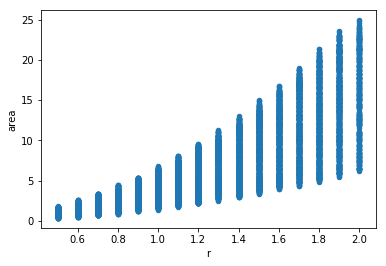

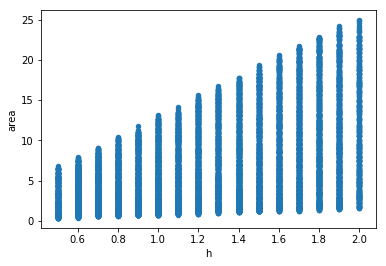

In [69]:
df=newDataset(10000,True)
df.plot(x='r',y='area',kind='scatter')
df.plot(x='h',y='area',kind='scatter')

In [70]:
def make_input_fn(df):
    return tf.estimator.inputs.pandas_input_fn(df,df['area'],128,10,shuffle=True,queue_capacity=1000)
def make_eval_input_fn(df):
    return tf.estimator.inputs.pandas_input_fn(df,df['area'],1,1,shuffle=False,queue_capacity=1000)
def make_predict_input_fn(df):
    return tf.estimator.inputs.pandas_input_fn(df,None,128,1,shuffle=False,queue_capacity=1000)

In [71]:
feature_cols=[tf.feature_column.numeric_column('r'),tf.feature_column.numeric_column('h')]
estimator=tf.estimator.DNNRegressor(hidden_units=[64,32],
                                    feature_columns=feature_cols,
                                    model_dir='outputs/tf_week2/challenge1',
                                    optimizer='Adam')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_model_dir': 'outputs/tf_week2/challenge1', '_train_distribute': None, '_task_type': 'worker', '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc0b808f588>, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_evaluation_master': '', '_is_chief': True, '_device_fn': None, '_service': None, '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5}


In [75]:
estimator.train(make_input_fn(df),steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from outputs/tf_week2/challenge1/model.ckpt-2346
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2346 into outputs/tf_week2/challenge1/model.ckpt.
INFO:tensorflow:loss = 32.707115, step = 2346
INFO:tensorflow:global_step/sec: 192.687
INFO:tensorflow:loss = 50.830605, step = 2446 (0.523 sec)
INFO:tensorflow:global_step/sec: 248.042
INFO:tensorflow:loss = 16.97633, step = 2546 (0.404 sec)
INFO:tensorflow:global_step/sec: 208.153
INFO:tensorflow:loss = 15.704245, step = 2646 (0.482 sec)
INFO:tensorflow:global_step/sec: 208.497
INFO:tensorflow:loss = 26.222275, step = 2746 (0.478 sec)
INFO:tensorflow:global_step/sec: 210.661
INFO:tensorflow:loss = 14.596633, step = 2846 (0.474 sec)
INFO:tensorflow:global_step/sec: 213.893
INFO:te

In [76]:
df=newDataset(500,True)
estimator.evaluate(make_eval_input_fn(df))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-11-17:19:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from outputs/tf_week2/challenge1/model.ckpt-3128
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-11-17:19:18
INFO:tensorflow:Saving dict for global step 3128: average_loss = 0.28789565, global_step = 3128, loss = 0.28789565
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3128: outputs/tf_week2/challenge1/model.ckpt-3128


{'average_loss': 0.28789565, 'global_step': 3128, 'loss': 0.28789565}

In [67]:
db=newDataset(50,True)
predict_gen=estimator.predict(make_predict_input_fn(db))
for i in range(len(db)):
    label=float(db.iloc[i]['area'])
    predict_label=next(predict_gen)['predictions'][0]
    print('label value is {},predict value is {}'.format(label,predict_label))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from outputs/tf_week2/challenge1/model.ckpt-9384
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
label value is 11.4,predict value is 11.324389457702637
label value is 13.8,predict value is 14.430193901062012
label value is 10.4,predict value is 10.16899299621582
label value is 2.0,predict value is 1.9330623149871826
label value is 14.8,predict value is 13.811942100524902
label value is 3.7,predict value is 3.4170758724212646
label value is 3.1,predict value is 2.9977903366088867
label value is 1.9,predict value is 2.005169153213501
label value is 2.8,predict value is 2.5514650344848633
label value is 5.1,predict value is 4.6897149085998535
label value is 2.4,predict value is 2.3997652530670166
label value is 5.1,predict value is 5.498105525970459
label value is 9.6,predict value is 9.916967391967773
label 

float